# **optimizing spam filtering with mechine learning**




In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [4]:
url = 'https://raw.githubusercontent.com/ShresthaSudip/SMS_Spam_Detection_DNN_LSTM_BiLSTM/master/SMSSpamCollection'
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [5]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label  \
103   ham   
154   ham   
207   ham   
223   ham   
326   ham   

                                                                                                 message  
103  As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...  
154  As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your call...  
207  As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch....  
223                                                                               Sorry, I'll call later  
326                                                                     No calls..messages..missed calls  


# new section 

In [49]:
#Give concise summary of a DataFramedf.info()
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                                                                          spam  
message count                                                                                                   747  
        unique                                                                                                  653  
        top     Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as y...  
        freq                                                                                                      4

In [11]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                                                                          spam  
message count                                                                                                   747  
        unique                                                                                                  653  
        top     Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as y...  
        freq                                                                                                      4

In [12]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

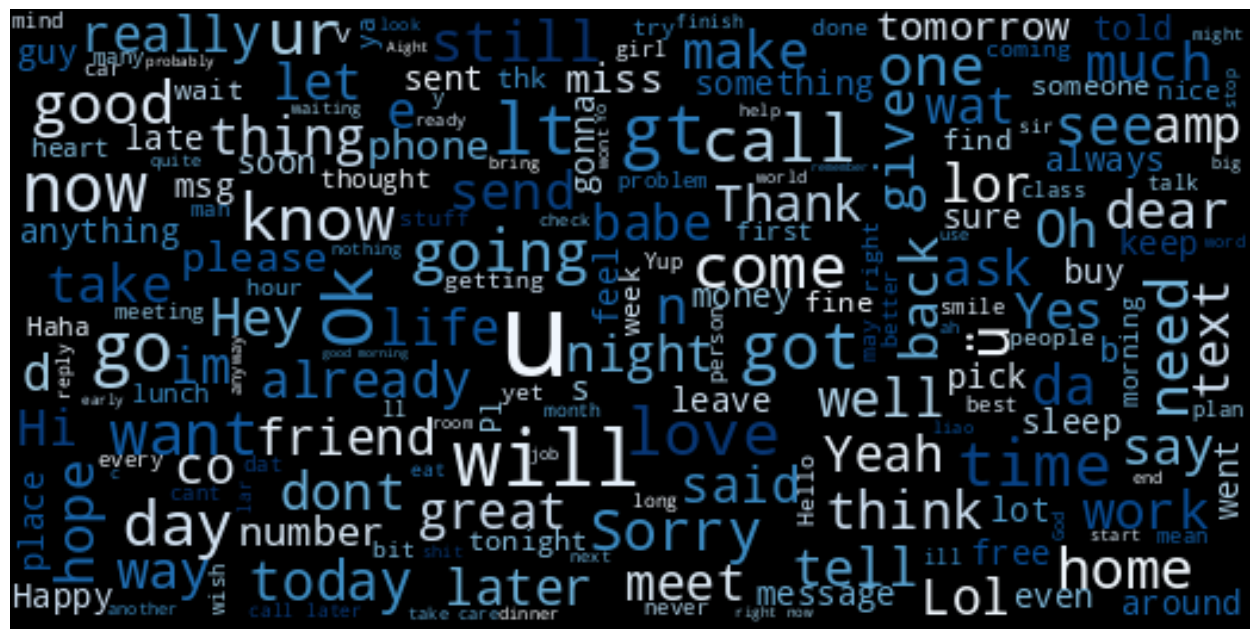

In [13]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

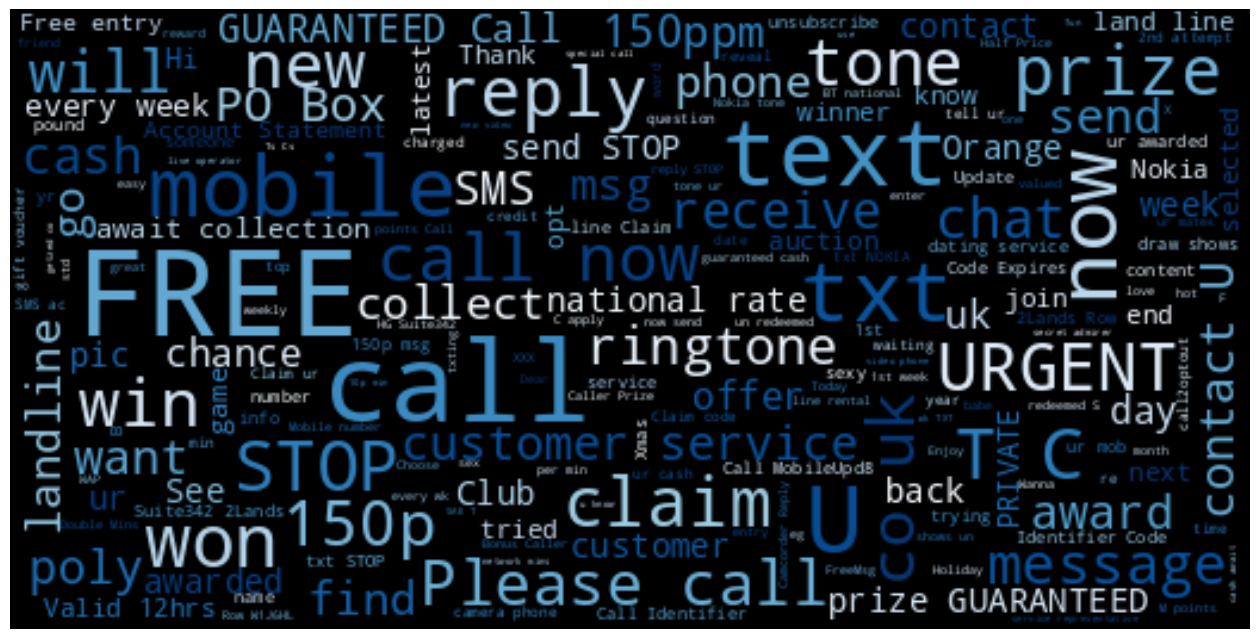

In [14]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

15.481865284974095


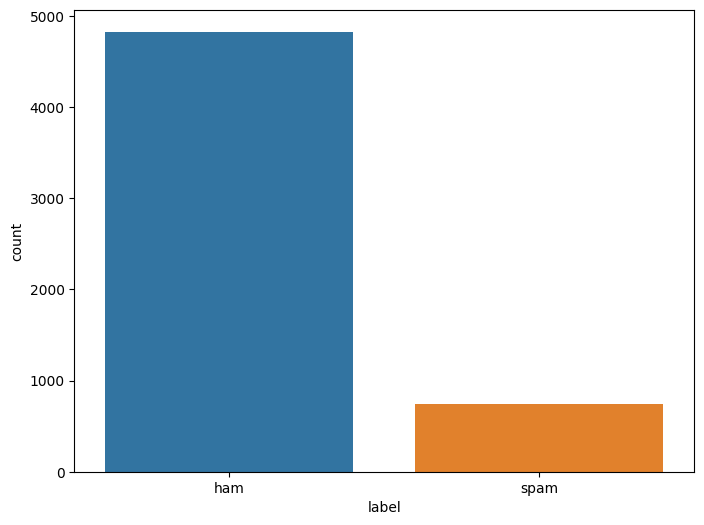

In [50]:
# we can observe imbalance data here
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=messages)
# Percentage of spam messages
print((len(spam_msg)/len(ham_msg))*100 )# 15.48%

In [17]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


<ipython-input-51-93dc43830857>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)


Text(0.5, 0, 'Message types')

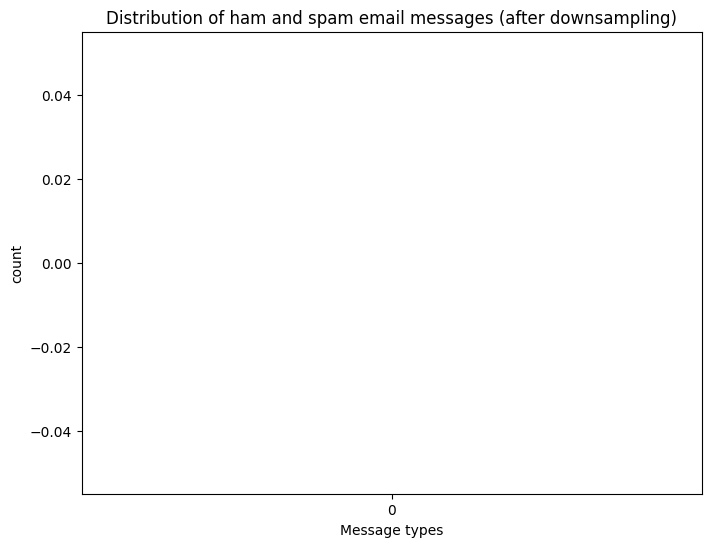

In [51]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot()
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [19]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,73.238286
spam,138.670683


In [20]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [21]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [22]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [23]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [24]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


In [25]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [26]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [27]:
print(len(training_sequences[0]), len(training_sequences[1]))

27 24


In [28]:
print(len(training_padded[0]), len(training_padded[1]))

50 50


In [29]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [30]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [31]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [34]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6816 - accuracy: 0.6594 - val_loss: 0.6687 - val_accuracy: 0.7726 - 1s/epoch - 31ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6471 - accuracy: 0.8218 - val_loss: 0.6237 - val_accuracy: 0.8094 - 130ms/epoch - 3ms/step
Epoch 3/30
38/38 - 0s - loss: 0.5897 - accuracy: 0.8586 - val_loss: 0.5587 - val_accuracy: 0.8361 - 120ms/epoch - 3ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5140 - accuracy: 0.8720 - val_loss: 0.4849 - val_accuracy: 0.8595 - 125ms/epoch - 3ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4336 - accuracy: 0.8862 - val_loss: 0.4078 - val_accuracy: 0.8595 - 116ms/epoch - 3ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3539 - accuracy: 0.9079 - val_loss: 0.3473 - val_accuracy: 0.8796 - 114ms/epoch - 3ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3012 - accuracy: 0.9038 - val_loss: 0.3005 - val_accuracy: 0.8863 - 117ms/epoch - 3ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2495 - accuracy: 0.9255 - val_loss: 0.2623 - val_accuracy: 0.8963 - 145ms/epoch - 4ms/step
Epoch 9/30
38/38 -

In [36]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 0.1234 - accuracy: 0.9431


[0.1234022006392479, 0.9431437849998474]

In [37]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

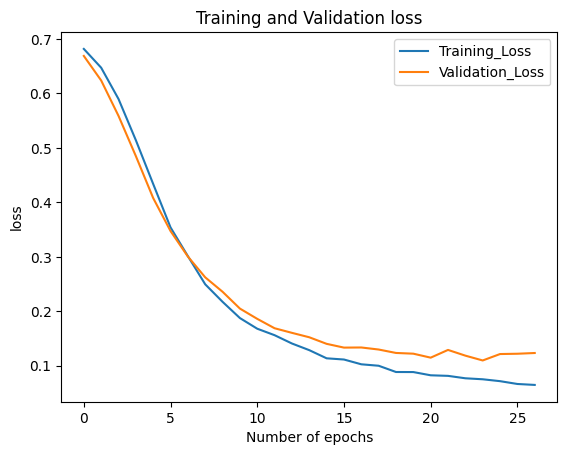

In [38]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

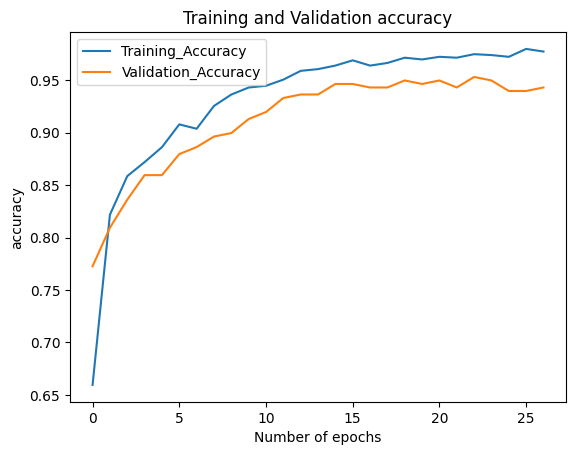

In [39]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [40]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [41]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [42]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

1/1 [==============================] - 0s 212ms/step


array([[0.01222703],
       [0.0074722 ],
       [0.99967027]], dtype=float32)

In [43]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

1/1 [==============================] - 0s 22ms/step


array([[0.9247769 ],
       [0.0499527 ],
       [0.02105983]], dtype=float32)

In [44]:
model.save("spam.h5")